In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.circuit.library.basis_change.qft import QFT
import math
import numpy as np
from qiskit.algorithms import VQE
# from qiskit_nature.algorithms import (GroundStateEigensolver,
#                                       NumPyMinimumEigensolverFactory)
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper

import matplotlib.pyplot as plt
import numpy as np
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit.opflow import TwoQubitReduction
from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import  QAOA, VQE, NumPyMinimumEigensolver
from qiskit_optimization.applications import Knapsack
from qiskit_optimization.converters import QuadraticProgramToQubo

from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import algorithm_globals, QuantumInstance

import time
import itertools

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Otimização na criação de um portfolio


Vamos supor que queremos montar um portfolio de finanças. Precisamos, portanto, escolher algumas ações dentre um conjunto. Cada uma destas ações tem dois atributos:
* Investimento (valor a ser investido)
* Retorno (quando isso irá render)

Temos também um limite de quanto podemos investir naquele portfolio.

Desta forma, precisamos determinar quais ações incluir nesse portfolio, com o objetivo de maximizar o retorno, respeitando a restrição do limite de investimento.

Assim, para cada ação, temos a opção de incluí-la ou não. Nenhuma ação pode ser quebrada, ou seja, não podemos investir em apenas parte dela.

Este problema é um exemplo específico do famoso Problema da Mochila Binária e pertence à classe dos problemas de otimização, em que buscamos a melhor resposta dentre todas as soluções viáveis.

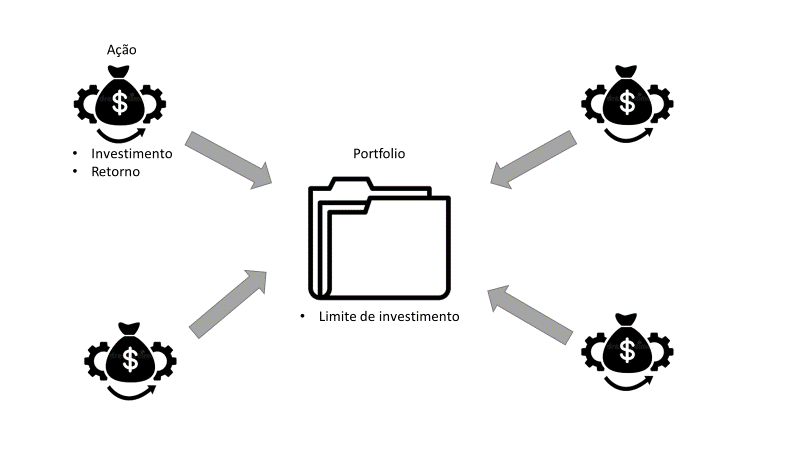

## Criando portfolios

Vamos começar criando possíveis portfolios.

In [2]:
def create_knapsack(items, W):
    WT = [v[0] for v in items]
    VAL = [v[1] for v in items]
    return WT, VAL

In [3]:
import random

list_total_itens = [2,5,9,13] #[2,5,7,9,13,16]
max_weight = random.randint(20,40)

knapsacks = []
for total_itens in list_total_itens:
    knapsack_items = []
    for i in range(total_itens):
        knapsack_items.append((random.randint(1,20), random.randint(1,20)))  #peso, valor
    knapsack = (knapsack_items, max_weight)
    knapsacks.append(knapsack)

In [4]:
for k in knapsacks:
    print("-"*20, "Tamanho do portfolio: ", len(k[0]), " ", "-"*20, "\n", k, "\n")

-------------------- Tamanho do portfolio:  2   -------------------- 
 ([(17, 13), (3, 1)], 35) 

-------------------- Tamanho do portfolio:  5   -------------------- 
 ([(20, 9), (15, 12), (17, 20), (20, 8), (17, 17)], 35) 

-------------------- Tamanho do portfolio:  9   -------------------- 
 ([(18, 11), (18, 15), (13, 1), (18, 4), (17, 17), (19, 6), (12, 5), (13, 16), (10, 10)], 35) 

-------------------- Tamanho do portfolio:  13   -------------------- 
 ([(19, 10), (2, 7), (19, 1), (16, 15), (18, 16), (5, 15), (3, 2), (1, 19), (18, 19), (16, 17), (16, 4), (3, 11), (11, 17)], 35) 



### Construindo o problema 

A biblioteca do Qiskit já possui uma biblioteca interna que inclui o problema da Mochila Binária. Vamos utilizar essa biblioteca para o nosso problema de montagem de portfolio.


In [5]:
items, W = knapsacks[0]
WT, VAL = create_knapsack(items, W)

In [6]:
prob = Knapsack(values = VAL, weights = WT, max_weight=W)
print(
"-"*15, " Knapsack " ,"-"*15, "\n",
"Custos: ", prob._values,"\n",
"Retornos: ", prob._weights,"\n",
"Limite de investimento: ", prob.max_weight,

)

---------------  Knapsack  --------------- 
 Custos:  [13, 1] 
 Retornos:  [17, 3] 
 Limite de investimento:  35


### Transformando em programa quadrático
Os problemas de otimização neste módulo são representados com a classe QuadraticProgram, que é uma representação genérica para problemas de otimização.

https://qiskit.org/documentation/optimization/tutorials/02_converters_for_quadratic_programs.html

In [7]:
quadratic_program = prob.to_quadratic_program()

In [8]:
print(quadratic_program.prettyprint())

Problem name: Knapsack

Maximize
  13*x_0 + x_1

Subject to
  Linear constraints (1)
    17*x_0 + 3*x_1 <= 35  'c0'

  Binary variables (2)
    x_0 x_1




Podemos ver que o Programa Quadrático é capaz de resumir eficientemente nosso problema, afirmando que precisamos maximizar os valores, embora sujeitos à restrição linear relacionada ao limite de investimentos.

Cada uma dessas variáveis (x_i) é uma representação binária de um item, indicando se devemos ou não incluí-lo no portfolio. Em outras palavras, se um valor x_i for igual a 1, isso significa que devemos colocar a ação na portfolio. Se for 0, não devemos incluí-lo.


No problema descrito acima, desejamos maximizar o valor do retorno. Isso é expresso pela soma das multiplicações entre o valor de uma ação e sua representação binária.

Por exemplo, se tivermos 3 variáveis binárias: x_0 com o valor 4, x_1 com o valor 3 e x_2 com o valor 4, o valor total do nosso portfolio pode ser expresso da seguinte forma: 4 * x_0 + 3 * x_1 + 4 * x_2.

Assim, por exemplo, se nossa solução for incluir os itens 1 e 2, nossa expressão resultante seria a seguinte: 4 * 0 + 3 * 1 + 4 * 1 = 7. Ou seja, para esta solução para o nosso portfolio teria o valor 7.


A restrição linear relacionada à restrição de peso da mochila pode ser expressa de forma semelhante. 

In [9]:
def get_operator_matrix(prob):
    quadratic_program = prob.to_quadratic_program()
    # qubo = QuadraticProgramToQubo().convert(quadratic_program)
    # operator, offset = qubo.to_ising()
    return quadratic_program# qubo, operator, operator.to_matrix()

In [10]:
start = time.time()
qubo = get_operator_matrix(prob)
end = time.time()
print("Elapsed time: ", end - start)

Elapsed time:  0.005174398422241211


## Solução com os otimizadores do Qiskit

### Resolvendo o problema usando NumPyMinimumEigensolver (solução clássica)

O NumPyMinimumEigensolver implementa uma abordagem clássica para encontrar a solução para o nosso problema.
Ele retorna um booleano relacionado a cada valor para indicar se deve considerar esse valor ou não.

### Resolvendo o problema usando QAOA (Quantum Approximate Optimization Algorithm)

Este algoritmo consiste em uma técnica híbrida clássico-quântica que pode ser usada para encontrar soluções aproximadas para problemas de otimização combinatória. É importante ressaltar que a metodologia QAOA consiste em um algoritmo heurístico. Assim, não garante necessariamente o melhor desempenho.

Referência: https://learn.qiskit.org/course/ch-applications/resolution-combinatorial-optimization-problems-using-qaoa

### Resolvendo o problema usando VQE (Variational Quantum Eigensolver)

Outro algoritmo de otimização quântica que pode ser usado para resolver nosso problema consiste no VQE. É um algoritmo híbrido que usa computação clássica e quântica para encontrar o estado fundamental de um determinado sistema físico. Dada uma estimativa inicial, ele calcula o valor esperado do sistema em relação a um hamiltoniano e um otimizador clássico é usado para melhorar o chute inicial.

In [11]:
algorithm_globals.massive = True

In [12]:
def solve_problem(knapsacks, solver_type):
    computing_times_quantum = []
    i=1
    for k in knapsacks:

        items = k[0]
        W=k[1]
        WT, VAL = create_knapsack(items, W)
        
        prob = Knapsack(values = VAL, weights = WT, max_weight=W)
        quadratic_program = prob.to_quadratic_program()
        
        qp2qubo = QuadraticProgramToQubo()
        qubo = qp2qubo.convert(quadratic_program)
        qubitOp, offset = qubo.to_ising()

        start = time.time()
        
        seed = 123
        algorithm_globals.random_seed = seed
        qins = QuantumInstance(backend=Aer.get_backend('qasm_simulator'), seed_simulator=seed, seed_transpiler=seed)
        
        if solver_type == 'classic':
            meo = MinimumEigenOptimizer(min_eigen_solver=NumPyMinimumEigensolver())
        elif solver_type == 'qaoa':
            meo = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=1, quantum_instance=qins))
        elif solver_type == 'vqe':
            meo = MinimumEigenOptimizer(min_eigen_solver=VQE(quantum_instance=qins))
        else:
            print("Solver not recognized")
            return 
        
        result = meo.solve(quadratic_program)

        computing_times_quantum.append((i, len(k[0]) , result, prob.interpret(result), time.time() - start))
        i+=1
    return computing_times_quantum

In [13]:
def show_results(computing_times):
    times = []
    for t in computing_times:
        print(
            "Knapsack ", t[0], ":   ",
            "Number of items: ", t[1], " | ",
            "Result: ", t[2], " | ",
            "Items chosen: ", t[3], " | ",
            "Computing time: ", t[4]
        )
        times.append((t[4]))
    return times


In [14]:
computing_times_classic = solve_problem(knapsacks, 'classic')

In [15]:
computing_times_qaoa = solve_problem(knapsacks, 'qaoa')

In [16]:
computing_times_vqe = solve_problem(knapsacks, 'vqe')

In [17]:
times_classic = show_results(computing_times_classic)

Knapsack  1 :    Number of items:  2  |  Result:  fval=14.0, x_0=1.0, x_1=1.0, status=SUCCESS  |  Items chosen:  [0, 1]  |  Computing time:  0.1746959686279297
Knapsack  2 :    Number of items:  5  |  Result:  fval=37.0, x_0=0.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, status=SUCCESS  |  Items chosen:  [2, 4]  |  Computing time:  0.29949164390563965
Knapsack  3 :    Number of items:  9  |  Result:  fval=33.0, x_0=0.0, x_1=0.0, x_2=0.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=1.0, x_8=0.0, status=SUCCESS  |  Items chosen:  [4, 7]  |  Computing time:  3.665930986404419
Knapsack  4 :    Number of items:  13  |  Result:  fval=75.0, x_0=0.0, x_1=1.0, x_2=0.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=1.0, x_8=0.0, x_9=1.0, x_10=0.0, x_11=0.0, x_12=1.0, status=SUCCESS  |  Items chosen:  [1, 5, 7, 9, 12]  |  Computing time:  90.12743377685547


In [18]:
times_qaoa = show_results(computing_times_qaoa)

Knapsack  1 :    Number of items:  2  |  Result:  fval=14.0, x_0=1.0, x_1=1.0, status=SUCCESS  |  Items chosen:  [0, 1]  |  Computing time:  1.9020674228668213
Knapsack  2 :    Number of items:  5  |  Result:  fval=37.0, x_0=0.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, status=SUCCESS  |  Items chosen:  [2, 4]  |  Computing time:  146.82022285461426
Knapsack  3 :    Number of items:  9  |  Result:  fval=32.0, x_0=0.0, x_1=1.0, x_2=0.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=0.0, x_7=0.0, x_8=0.0, status=SUCCESS  |  Items chosen:  [1, 4]  |  Computing time:  394.68315029144287
Knapsack  4 :    Number of items:  13  |  Result:  fval=73.0, x_0=0.0, x_1=1.0, x_2=0.0, x_3=0.0, x_4=0.0, x_5=0.0, x_6=0.0, x_7=1.0, x_8=1.0, x_9=0.0, x_10=0.0, x_11=1.0, x_12=1.0, status=SUCCESS  |  Items chosen:  [1, 7, 8, 11, 12]  |  Computing time:  441.8322389125824


In [19]:
times_vqe = show_results(computing_times_vqe)

Knapsack  1 :    Number of items:  2  |  Result:  fval=14.0, x_0=1.0, x_1=1.0, status=SUCCESS  |  Items chosen:  [0, 1]  |  Computing time:  6.194522380828857
Knapsack  2 :    Number of items:  5  |  Result:  fval=37.0, x_0=0.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, status=SUCCESS  |  Items chosen:  [2, 4]  |  Computing time:  48.38004779815674
Knapsack  3 :    Number of items:  9  |  Result:  fval=31.0, x_0=0.0, x_1=0.0, x_2=0.0, x_3=0.0, x_4=0.0, x_5=0.0, x_6=1.0, x_7=1.0, x_8=1.0, status=SUCCESS  |  Items chosen:  [6, 7, 8]  |  Computing time:  252.18891382217407
Knapsack  4 :    Number of items:  13  |  Result:  fval=71.0, x_0=0.0, x_1=1.0, x_2=0.0, x_3=0.0, x_4=0.0, x_5=0.0, x_6=0.0, x_7=1.0, x_8=0.0, x_9=1.0, x_10=0.0, x_11=1.0, x_12=1.0, status=SUCCESS  |  Items chosen:  [1, 7, 9, 11, 12]  |  Computing time:  620.7358314990997


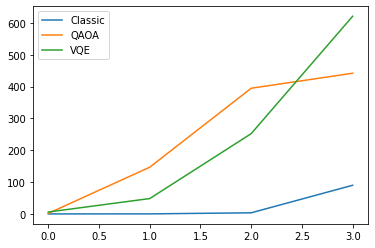

In [20]:
plt.plot(times_classic, label = "Classic")
plt.plot(times_qaoa, label = "QAOA")
plt.plot(times_vqe, label = "VQE")

plt.legend()
plt.show()

## Rodando em um computador quântico real

Vamos testar nossas soluções em um computador quântico real!

Nesse caso, é importante lembrar que os computadores quânticos reais têm uma limitação de número de qubits para executar programas. A maioria dos sistemas quânticos disponíveis gratuitamente na IBM tem uma limitação de no máximo 5 a 7 qubits por aplicativo. As especificações e o número atual de jobs pendentes em cada sistema IBM disponível estão descritos no link a seguir:

https://quantum-computing.ibm.com/services/resources?tab=yours&status=Online&resourceType=systems

In [21]:
backend = provider.get_backend('ibm_oslo')
# backend = provider.get_backend('ibmq_manila')
backend

<IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>

In [30]:
knapsack1 = ([(3, 4), (2, 3)], 4)

In [ ]:
computing_times_real_quantum = []

i=1
k = knapsack1
items = k[0]
W=k[1]
WT, VAL = create_knapsack(items, W)
prob = Knapsack(values = VAL, weights = WT, max_weight=W)

quadratic_program = prob.to_quadratic_program()

try:
    start = time.time()
    meo = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=1, quantum_instance=backend))
    result = meo.solve(quadratic_program)

    computing_times_real_quantum.append((i, len(k[0]) , result, prob.interpret(result), time.time() - start))
except:
    print("Qubit number limitation")
i+=1

In [ ]:
times_quantum_real = []
for t in computing_times_real_quantum:
    print(
        "Knapsack ", t[0], ":   ",
        "Number of items: ", t[1], " | ",
        "Result: ", t[2], " | ",
        "Items chosen: ", t[3], " | ",
        "Computing time: ", t[4]
    )
    times_quantum_real.append((t[4]))

--------------

## Exemplo de criação de circuitos

Vamos agora descobrir como criar um circuito!

Baseado no problema anterior, vamos criar um circuito de adição.

In [22]:
def add(n1,n2, display_circuit=False): 
       
    b1 = str(bin(n1))[2:]
    b2 = str(bin(n2))[2:]
    
    b1 = ((len(b1)//2)+1)*'0' + b1
    b2 = ((len(b2)//2)+1)*'0' + b2
    
    n=max(len(b1),len(b2))
         
    # Criando os registradores
    ## O registrador quântico contém os qubits e serão utilizados nas operações matriciais
    reg_n1=QuantumRegister(n,'n1')
    reg_n2=QuantumRegister(n,'n2')
    ## O registrador clássico contém os bits que serão utilizados no processo de medição
    classic_reg=ClassicalRegister(n,'classic')
    qc=QuantumCircuit(reg_n1,reg_n2,classic_reg)
    
    
    ## Inicializando o circuito
    initial_state = [1,0]   
    for j in range(2*n):
        qc.initialize(initial_state, j) 
    
    for i in range(0,len(b1)):
        if int(b1[i]) == 1:
            qc.x(len(b1)-1-i)
    for i in range(0,len(b2)):
        if int(b2[i]) == 1:
            qc.x(n+(len(b2)-1-i))
            
    qc.append(QFT(n, do_swaps=False),[i for i in range(n)])
    for i in range(n):
        for j in range(i+1):  
            qc.cp(math.pi/2**(i-j),reg_n2[j],reg_n1[i])

    qc.append(QFT(n, do_swaps=False).inverse(),[i for i in range(n)])
    for i in range(n):
        qc.measure(i,i)
        
    if display_circuit:
        display(qc.draw())
   
    shots_num = 10000
    job = execute(qc, Aer.get_backend("qasm_simulator"), shots = shots_num)

    result = job.result()
    counts = result.get_counts()
    
    if int(list(counts.keys())[0],2)<n1 or int(list(counts.keys())[0],2)<n2:
        shots_num = 10000
        job = execute(qc, Aer.get_backend("qasm_simulator"), shots = shots_num)

        result = job.result()
        counts = result.get_counts()
    number_result = int(list(counts.keys())[0],2)
    
    return number_result

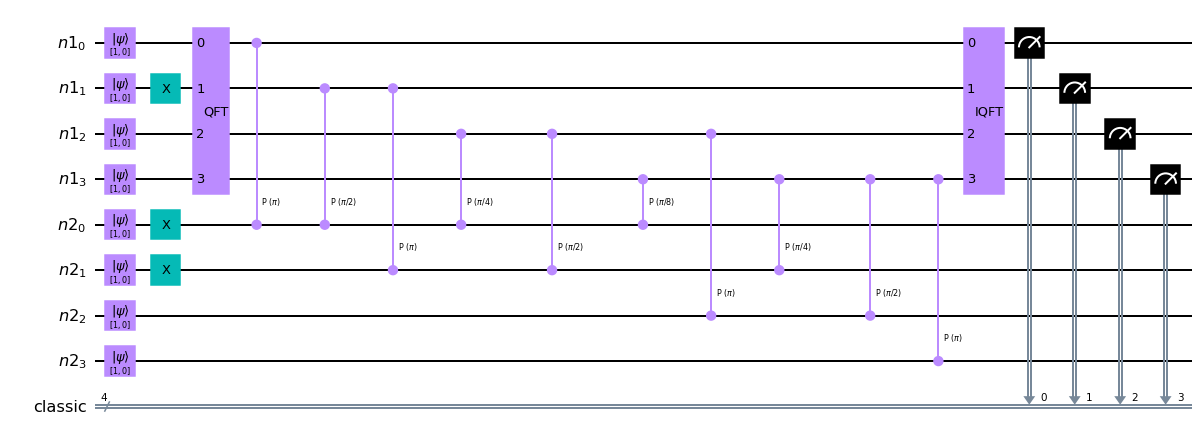

5

In [23]:
## Addition example
add(2,3, display_circuit=True)

# Referências

https://iopscience.iop.org/article/10.1088/1742-6596/735/1/012083/pdf

https://github.com/qiskit-community/ibm-quantum-challenge-fall-2021/blob/main/solutions-by-authors/challenge-4/challenge-4.ipynb

https://qiskit.org/documentation/stable/0.25/_modules/qiskit/optimization/applications/ising/knapsack.html#get_operator

https://github.com/Qiskit/qiskit-optimization/blob/main/docs/tutorials/06_examples_max_cut_and_tsp.ipynb

In [ ]:
times_classic = show_results(computing_times_classic)